In [2]:
suppressMessages(suppressWarnings({library(dplyr)
library(Seurat)
library(tidyverse)
library(openxlsx)
library(ggplot2)
library(sctransform)
library(pheatmap)
library(ggrepel)
library(reticulate)
library(EnhancedVolcano)
library(clustree)
library(phateR)
library(Rmagic)
library(EnhancedVolcano)
library(stringr)
library(glmGamPoi)
library(presto)
library(patchwork)
library(Azimuth)
library(data.table)
library(clusterProfiler)
library(org.Mm.eg.db)                             
library(biomaRt)
require(DOSE)}))

In [4]:
# Generate output directory name with current date
# current_date <- format(Sys.Date(), "%Y%m%d")
outDir <- "scRNAseq_results_updated"
ifelse(dir.exists(outDir), NA, dir.create(outDir))

[1] NA

In [11]:
load("seurat_int_after_PrepSCTFindMarkers_20250828.Rdata")

In [12]:
#finding cell markers by cluster
markers <- FindAllMarkers(object = seurat_int, only.pos = TRUE,
                                    min.pct = 0.25,  thresh.use = 0.25, 
                                    assay = "SCT")

write.xlsx(markers, file=paste(outDir, "markersSCT.xlsx",sep="/"), 
           overwrite = T, rowNames=T, colNames=T)

markersdf <- rownames_to_column(markers, var = "gene_symbol")


Calculating cluster 0

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating

In [13]:
save(markers, file = "find_all_markers.Rdata")

In [14]:
# this cell is to annotate the genes found in FindAllMarkers

ensembl_mouse <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")

#renaming the markers df so that the raw can be reused

AllMarkers <- markersdf

#extracting gene annotations
annotations <- getBM(
        attributes = c("mgi_symbol", "mgi_description", "description", "go_id", "name_1006", "namespace_1003"),
        filters = "mgi_symbol",
        values = AllMarkers$gene_symbol,
        mart = ensembl_mouse)

localization <- annotations[annotations$namespace_1003 == "cellular_component", ]
localization_summary <- aggregate(name_1006 ~ mgi_symbol, localization, function(x) paste(unique(x), collapse = "; "))
colnames(localization_summary) <- c("gene_symbol", "localization")
# Summarize GO term names
go_term_summary <- aggregate(name_1006 ~ mgi_symbol, annotations, function(x) paste(unique(x), collapse = "; "))
colnames(go_term_summary) <- c("gene_symbol", "go_terms")
    
# Summarize GO IDs
go_id_summary <- aggregate(go_id ~ mgi_symbol, annotations, function(x) paste(unique(x), collapse = "; "))
colnames(go_id_summary) <- c("gene_symbol", "go_ids")

# Summarize gene description
description_summary <- aggregate(mgi_description ~ mgi_symbol, annotations, function(x) paste(unique(x), collapse = "; "))
colnames(description_summary) <- c("gene_symbol", "gene_description")                         

                           
                           
# Merge all annotation summaries
AllMarkers <- merge(AllMarkers, localization_summary, by = "gene_symbol", all.x = TRUE)
AllMarkers <- merge(AllMarkers, go_term_summary, by = "gene_symbol", all.x = TRUE)
AllMarkers <- merge(AllMarkers, go_id_summary, by = "gene_symbol", all.x = TRUE)                          
AllMarkers <- merge(AllMarkers, description_summary, by = "gene_symbol", all.x = TRUE)                           
    
# Annotate secreted genes
secreted <- annotations[grepl("secretion|extracellular", annotations$name_1006, ignore.case = TRUE), ]                           
AllMarkers$secreted <- AllMarkers$gene_symbol %in% secreted$mgi_symbol
AllMarkers <- AllMarkers[order(AllMarkers$cluster, -AllMarkers$avg_log2FC), ]
write.xlsx(AllMarkers, file = file.path(outDir, "AllCellMarkers_annotated.xlsx"),
    rowNames = FALSE, colNames = TRUE, overwrite = TRUE)                           
                           

In [10]:
#this cell performs GSEA analysis of all clusters found in findAllMarkers and saves results in seperate sheets in an xlsx file
#also does BP terms plots and saves them all in a pdf file

marker <- read.xlsx("scRNAseq_results_updated/markersSCT.xlsx", colNames = T)
marker = marker[,-1]
marker = as_tibble(marker)
marker <- marker %>% dplyr::select(gene, everything())

cluster_list <- lapply(unique(marker$cluster), function(clust) {
  marker[marker$cluster == clust, ]})


names(cluster_list) <- paste0("cluster_", unique(marker$cluster))

wb_gsea <- createWorkbook()
pdf(file.path(outDir, "GSEA_plotsall_Clusters.pdf"), width = 8, height = 10)

for (i in seq_along(cluster_list)) {
  message("Processing: ", names(cluster_list)[i])
  df <- cluster_list[[i]]
  
  original_gene_list <- df$avg_log2FC
  names(original_gene_list) <- df$gene
  
  gene_list <- na.omit(original_gene_list)
  gene_list <- gene_list[!duplicated(names(gene_list))]
  gene_list <- sort(gene_list, decreasing = TRUE)

  gse <- suppressWarnings(suppressMessages(
    gseGO(
      geneList = gene_list,
      ont = "ALL",
      keyType = "SYMBOL",
      minGSSize = 3,
      maxGSSize = 800,
      pvalueCutoff = 0.05,
      verbose = TRUE,
      OrgDb = org.Mm.eg.db,
      pAdjustMethod = "fdr", scoreType = "pos")))

  gse_df <- as.data.frame(gse)
  gse_df <- gse_df[order(gse_df$ONTOLOGY), ]
  gse_df <- gse_df[gse_df$qvalue <= 0.05, ]

  if (nrow(gse_df) > 0) {
    sheet_name <- substr(paste(names(cluster_list)[i], "GSEA"), 1, 31)
    addWorksheet(wb_gsea, sheet_name)
    writeData(wb_gsea, sheet_name, gse_df, startRow = 1, startCol = 1)
      }

      #redoing gseGO for BP only, this will be used for the plots
  gseBP <- suppressWarnings(suppressMessages(
    gseGO(
      geneList = gene_list,
      ont = "BP",
      keyType = "SYMBOL",
      minGSSize = 3,
      maxGSSize = 800,
      pvalueCutoff = 0.05,
      verbose = TRUE,
      OrgDb = org.Mm.eg.db,
      pAdjustMethod = "fdr",
      scoreType = "pos")))

    if (nrow(as.data.frame(gseBP)) > 0) {

    dot <- dotplot(gseBP, showCategory = 10, split = ".sign") +
      facet_grid(. ~ .sign) +
      ggtitle(paste("DotPlot:", names(cluster_list)[i]))
    print(dot)

    ridge <- ridgeplot(gseBP, showCategory = 10) +
      labs(x = "enrichment distribution") +
      ggtitle(paste("RidgePlot:", names(cluster_list)[i])) +
      theme(axis.text.y = element_text(size = 8))
    print(ridge)

    cnet <- cnetplot(gseBP, categorySize = "pvalue", foldChange = gene_list, showCategory=3, circular = TRUE) +
      ggtitle(paste("CnetPlot:", names(cluster_list)[i]))
    print(cnet)

    } else {
        # Add a blank plot with a message
        message_plot <- ggplot() +
            theme_void() +
            ggtitle(paste("No gene set enrichment found for", names(cluster_list)[i]))
        print(message_plot)
    }
  
}
dev.off()

saveWorkbook(wb_gsea, file.path(outDir, "GSEA_analysis_allClusters.xlsx"), overwrite = TRUE)

Processing: cluster_0

Picking joint bandwidth of 0.0812

Processing: cluster_1

Picking joint bandwidth of 0.143

Processing: cluster_2

Picking joint bandwidth of 0.0733

Processing: cluster_3

Processing: cluster_4

Picking joint bandwidth of 0.108

Processing: cluster_5

Picking joint bandwidth of 0.154

Processing: cluster_6

Picking joint bandwidth of 0.164

Processing: cluster_7

Picking joint bandwidth of 0.0928

Processing: cluster_8

Processing: cluster_9

Picking joint bandwidth of 0.274

Processing: cluster_10

Picking joint bandwidth of 0.0627

Warning message:
"ggrepel: 63 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Processing: cluster_11

Picking joint bandwidth of 0.532

Processing: cluster_12

Picking joint bandwidth of 0.418

Processing: cluster_13

Picking joint bandwidth of 0.0869

Processing: cluster_14

Picking joint bandwidth of 0.198

Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.

agg_record_1926939747 
                    2

In [15]:
#This cell is to perform pairwise DE comparisons based on contrasts table and also annotate the genes
#GSEA loop is next cell because this was becoming too long

#sample level pairwise DE analsysis
seuratDE = seurat_int
seuratDE$sample <- paste(seuratDE$orig.ident, sep = "_")
Idents(seuratDE) <- "sample"

contrasts <- read.csv("contrasts.txt")
ensembl_mouse <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")

de_all <- createWorkbook()
de_sig <- createWorkbook()

for (i in 1:nrow(contrasts)) {
    
    # Extract contrast pair
    contrast <- as.character(contrasts[i, ])
    message("Processing: ", contrast[1], " vs ", contrast[2])
    
    # Find markers
    markersDF <- FindMarkers(seuratDE, ident.1 = contrast[1], ident.2 = contrast[2])
    markersDF <- rownames_to_column(markersDF, var = "gene_symbol")

    
    # Extract localization (cellular component GO terms)
    localization <- annotations[annotations$namespace_1003 == "cellular_component", ]
    
    # Summarize localization info
    localization_summary <- aggregate(name_1006 ~ mgi_symbol, localization, function(x) paste(unique(x), collapse = "; "))
    colnames(localization_summary) <- c("gene_symbol", "localization")
    
    # Summarize GO term names
    go_term_summary <- aggregate(name_1006 ~ mgi_symbol, annotations, function(x) paste(unique(x), collapse = "; "))
    colnames(go_term_summary) <- c("gene_symbol", "go_terms")
    
    # Summarize GO IDs
    go_id_summary <- aggregate(go_id ~ mgi_symbol, annotations, function(x) paste(unique(x), collapse = "; "))
    colnames(go_id_summary) <- c("gene_symbol", "go_ids")

    # Summarize gene description
    description_summary <- aggregate(mgi_description ~ mgi_symbol, annotations, function(x) paste(unique(x), collapse = "; "))
    colnames(description_summary) <- c("gene_symbol", "gene_description")                                 
    
    # Merge all annotation summaries
    markersDF <- merge(markersDF, localization_summary, by = "gene_symbol", all.x = TRUE)
    markersDF <- merge(markersDF, go_term_summary, by = "gene_symbol", all.x = TRUE)
    markersDF <- merge(markersDF, go_id_summary, by = "gene_symbol", all.x = TRUE)
    markersDF <- merge(markersDF, description_summary, by = "gene_symbol", all.x = TRUE)                                       
    
    # Annotate secreted genes    
    secreted <- annotations[grepl("secretion|extracellular", annotations$name_1006, ignore.case = TRUE), ]                               
    markersDF$secreted <- markersDF$gene_symbol %in% secreted$mgi_symbol
    
    # Filter significant markers
    sig_markers <- markersDF[markersDF$p_val_adj <= 0.05, ]
    sig_markers <- sig_markers[order(abs(sig_markers$avg_log2FC), decreasing = TRUE), ] #sorting by abs log2FC

    sheet_all <- substr(paste0(contrast[1], "_vs_", contrast[2]), 1, 31)
    addWorksheet(de_all, sheet_all)
    writeData(de_all, sheet_all, markersDF, startRow = 1, startCol = 1)

    sheet_sig <- substr(paste0(contrast[1], "_vs_", contrast[2]), 1, 31)
    addWorksheet(de_sig, sheet_sig)
    writeData(de_sig, sheet_sig, sig_markers, startRow = 1, startCol = 1)
    
}
saveWorkbook(de_all, file.path(outDir, "DE_All_markers.xlsx"), overwrite = TRUE)
saveWorkbook(de_sig, file.path(outDir, "DE_Sig_markers.xlsx"), overwrite = TRUE)                        

Processing: OF-ISX vs OF-DMSO

Processing: OM-ISX vs OM-DMSO

Processing: YF-ISX vs YF-DMSO

Processing: YM-ISX vs YM-DMSO

Processing: OF-ISX vs YF-ISX

Processing: OM-ISX vs YM-ISX



In [16]:
#This cell performs the GSEA analysis of all the findmarkers genes of all the pairwise comparisons

seuratDE = seurat_int
seuratDE$sample <- paste(seuratDE$orig.ident, sep = "_")
Idents(seuratDE) <- "sample"

contrasts <- read.csv("contrasts.txt")
de_gsea <- createWorkbook()
pdf(file.path(outDir, "GSEA_plots_pairwise_comparisons.pdf"), width = 8, height = 10)

for (i in 1:nrow(contrasts)) {
        # Extract contrast pair
    contrast <- as.character(contrasts[i, ])
    message("Processing: ", contrast[1], " vs ", contrast[2])
    
    # Find markers
    markersDF <- FindMarkers(seuratDE, ident.1 = contrast[1], ident.2 = contrast[2])
    markersDF <- rownames_to_column(markersDF, var = "gene_symbol")

    original_gene_list <- markersDF$avg_log2FC
    names(original_gene_list) <- markersDF$gene_symbol      
    gene_list <- na.omit(original_gene_list)
    gene_list <- gene_list[!duplicated(names(gene_list))]
    gene_list <- sort(gene_list, decreasing = TRUE)
    
    gse <- suppressWarnings(suppressMessages(gseGO(geneList=gene_list, 
             ont ="ALL", 
             keyType = "SYMBOL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = org.Mm.eg.db, pAdjustMethod = "fdr")))
    gse_df <- as.data.frame(gse)
    gse_df <- gse_df[order(gse_df$ONTOLOGY), ]
    gse_df <- gse_df[gse_df$qvalue <= 0.05, ]

    if (nrow(gse_df) > 0) {
    sheet_name <- substr(paste0(contrast[1], "_vs_", contrast[2], "_GSEA"), 1, 31)
    addWorksheet(de_gsea, sheet_name)
    writeData(de_gsea, sheet_name, gse_df, startRow = 1, startCol = 1)
        }

                              
    #redoing gseGO for BP only, this will be used for the plots
    gseBP <- suppressWarnings(suppressMessages(gseGO(geneList=gene_list, 
             ont ="BP", 
             keyType = "SYMBOL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.05, 
             verbose = TRUE, 
             OrgDb = org.Mm.eg.db, pAdjustMethod = "fdr")))

    if (nrow(as.data.frame(gseBP)) > 0) { 

    dot <- dotplot(gseBP, showCategory = 10, split = ".sign") +
      facet_grid(. ~ .sign) +
      ggtitle(paste("DotPlot-Enriched Biological Processes: ", paste0(contrast[1], "_vs_",contrast[2])))
    print(dot)

    ridge <- ridgeplot(gseBP, showCategory = 10) +
      labs(x = "enrichment distribution") +
      ggtitle(paste("RidgePlot-Enriched Biological Processes: ", paste0(contrast[1], "_vs_",contrast[2]))) +
      theme(axis.text.y = element_text(size = 8))
    print(ridge)

    cnet <- cnetplot(gseBP, categorySize = "pvalue", foldChange = gene_list, showCategory=3, circular = TRUE) +
      ggtitle(paste("CnetPlot-Enriched Biological Processes: ", paste0(contrast[1], "_vs_",contrast[2])))
    print(cnet)
        } else {
        # Add a blank plot with a message
        message_plot <- ggplot() +
            theme_void() +
            ggtitle(paste("No gene set enrichment found for: ", paste0(contrast[1], "_vs_",contrast[2])))
        print(message_plot)
    } 
}
dev.off()
saveWorkbook(de_gsea, file.path(outDir, "DE_markers_GSEA_allComparisons.xlsx"), overwrite = TRUE)

Processing: OF-ISX vs OF-DMSO

Picking joint bandwidth of 0.541

Processing: OM-ISX vs OM-DMSO

Picking joint bandwidth of 0.335

Warning message:
"ggrepel: 18 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Processing: YF-ISX vs YF-DMSO

Picking joint bandwidth of 0.54

Processing: YM-ISX vs YM-DMSO

Picking joint bandwidth of 1.25

Processing: OF-ISX vs YF-ISX

Picking joint bandwidth of 0.427

Processing: OM-ISX vs YM-ISX

Picking joint bandwidth of 1.35



agg_record_312928385 
                   2

In [17]:
library(easybio)

easybio has been updated with significant breaking changes in single-cell annotation workflow.
To learn the new workflow, please run:
  vignette("example-single-cell-annotation", package = "easybio")



In [18]:
vignette("example-single-cell-annotation", package = "easybio")

Warning message:
"vignette 'example-single-cell-annotation' not found"


Warning message in DoHeatmap(seurat_int, features = top10$gene):
"The following features were omitted as they were not found in the scale.data slot for the SCT assay: Gm26917, AY036118, Gm42418, Clec4b2, Ly6g, Tcrg-C1, Gm14548, Ms4a4c, Ifi207, Spacdr, Skic8, Septin7, Skp1, Ddx39a, H2az1, H2ax, Hist1h1b, H1f3, H1f1, H1f4, H2ac20, H4c4, Hist1h1a, H3c3, H2ac8, H1f5, Cdc25b"


agg_record_1749136997 
                    2

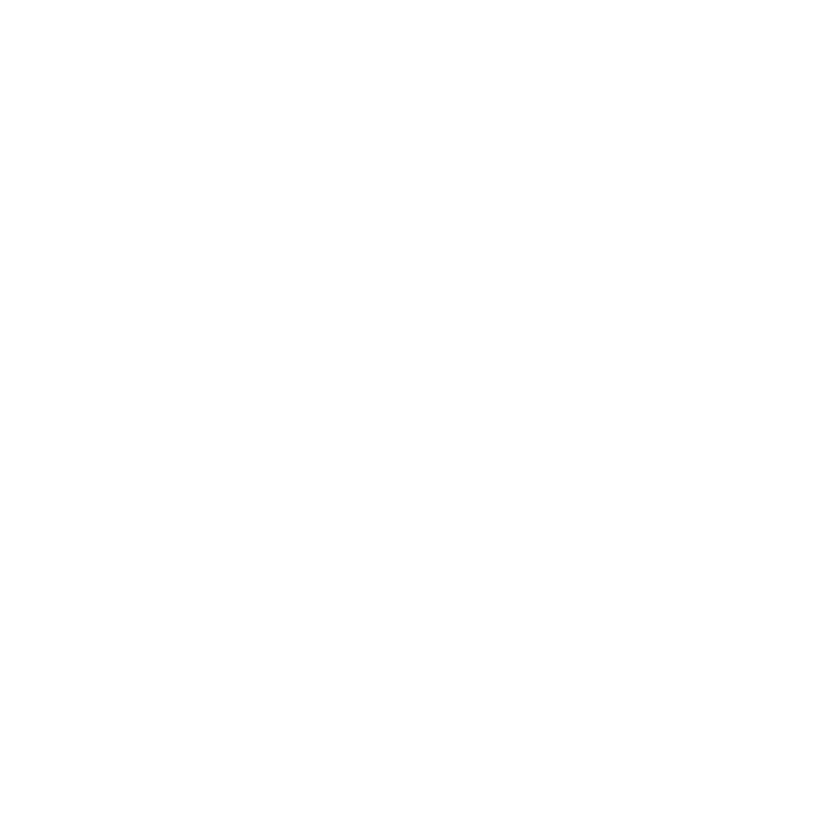

In [19]:
#top 10 genes by cluster
top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
write.xlsx(top10, file=paste(outDir, "top10_genes_byCluster.xlsx",sep="/"), 
           overwrite = T, rowNames=T, colNames=T)
#heatmap of top 10 genes by cluster
heatmap <- DoHeatmap(seurat_int, features = top10$gene) + NoLegend()
pdf(file = paste(outDir,"heatmap_top10_genes_byCluster.pdf",sep="/"), height = 14, width = 18)
heatmap
dev.off()
heatmap

In [20]:

#perforing cell typing using easybio
markerTop50Matched <- matchCellMarker2(marker= markers, n= 50, spc ="Mouse")
write.xlsx(markerTop50Matched, file=paste(outDir, "markers_top50matched.xlsx",sep="/"), rowNames=T, colNames=T)
markerTop50Matched[,head(.SD,3), by =cluster][,1:4]|>knitr::kable()



|cluster |cell_name                            | uniqueN|  N|
|:-------|:------------------------------------|-------:|--:|
|0       |Monocyte                             |       3|  8|
|0       |Naive T(Th0) cell                    |       1|  6|
|0       |Neutrophil                           |       3|  6|
|1       |Macrophage                           |       2|  3|
|1       |T cell                               |       1|  3|
|1       |Proliferative cell                   |       1|  3|
|2       |Proliferating T cell                 |       6|  6|
|2       |General epithelial cell              |       1|  1|
|2       |Distal Proliferative Progenitor cell |       1|  1|
|3       |Endothelial cell                     |       4|  9|
|3       |Neutrophil                           |       1|  6|
|3       |Hematopoietic stem cell              |       2|  4|
|4       |Endothelial cell                     |       1|  3|
|4       |Macrophage                           |       3|  3|
|4    

In [21]:
#perforing cell typing using easybio
markerTop50Matched <- matchCellMarker2(marker= markers, n= 50, spc ="Mouse")
write.xlsx(markerTop50Matched, file=paste(outDir, "markers_top50matched.xlsx",sep="/"), rowNames=T, colNames=T)
markerTop50Matched[,head(.SD,3), by =cluster][,1:4]|>knitr::kable()



|cluster |cell_name                            | uniqueN|  N|
|:-------|:------------------------------------|-------:|--:|
|0       |Monocyte                             |       3|  8|
|0       |Naive T(Th0) cell                    |       1|  6|
|0       |Neutrophil                           |       3|  6|
|1       |Macrophage                           |       2|  3|
|1       |T cell                               |       1|  3|
|1       |Proliferative cell                   |       1|  3|
|2       |Proliferating T cell                 |       6|  6|
|2       |General epithelial cell              |       1|  1|
|2       |Distal Proliferative Progenitor cell |       1|  1|
|3       |Endothelial cell                     |       4|  9|
|3       |Neutrophil                           |       1|  6|
|3       |Hematopoietic stem cell              |       2|  4|
|4       |Endothelial cell                     |       1|  3|
|4       |Macrophage                           |       3|  3|
|4    

agg_record_542516540 
                   2

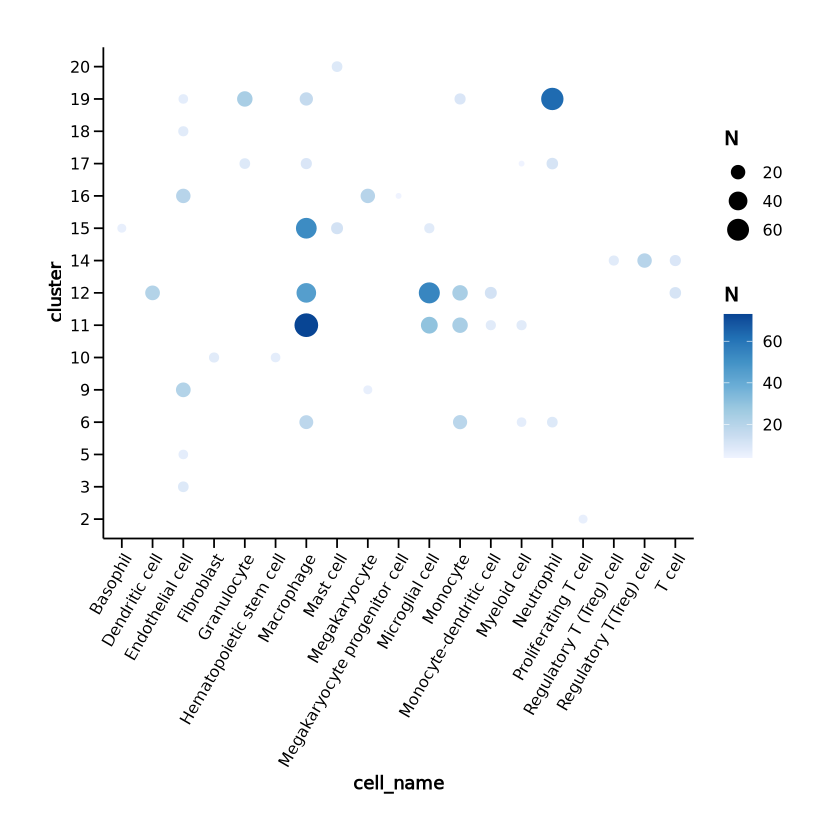

In [22]:
#plot precdicted cell type
celltype <- plotPossibleCell(markerTop50Matched[,head(.SD),by= cluster],min.uniqueN= 3)
pdf(file=paste(outDir,"PossibleCellType_bycluster.pdf",sep="/"))
celltype
dev.off()
celltype

0                         1                         2 
               "Monocyte"              "Macrophage"    "Proliferating T cell" 
                        3                         4                         5 
       "Endothelial cell"        "Endothelial cell"               "Stem cell" 
                        6                         7                         8 
               "Monocyte"          "Dendritic cell"          "Dendritic cell" 
                        9                        10                        11 
       "Endothelial cell"         "Epithelial cell"              "Macrophage" 
                       12                        13                        14 
        "Microglial cell" "Regulatory T(Treg) cell" "Regulatory T(Treg) cell" 
                       15                        16                        17 
             "Macrophage"        "Endothelial cell"                "Monocyte" 
                       18                        19                        20 
       "Endothelial cell"              "Neutrophil"                  "Neuron" 
                       21                        22 
     "Hepatobiliary cell" "Monocyte-dendritic cell"

agg_record_980816985 
                   2

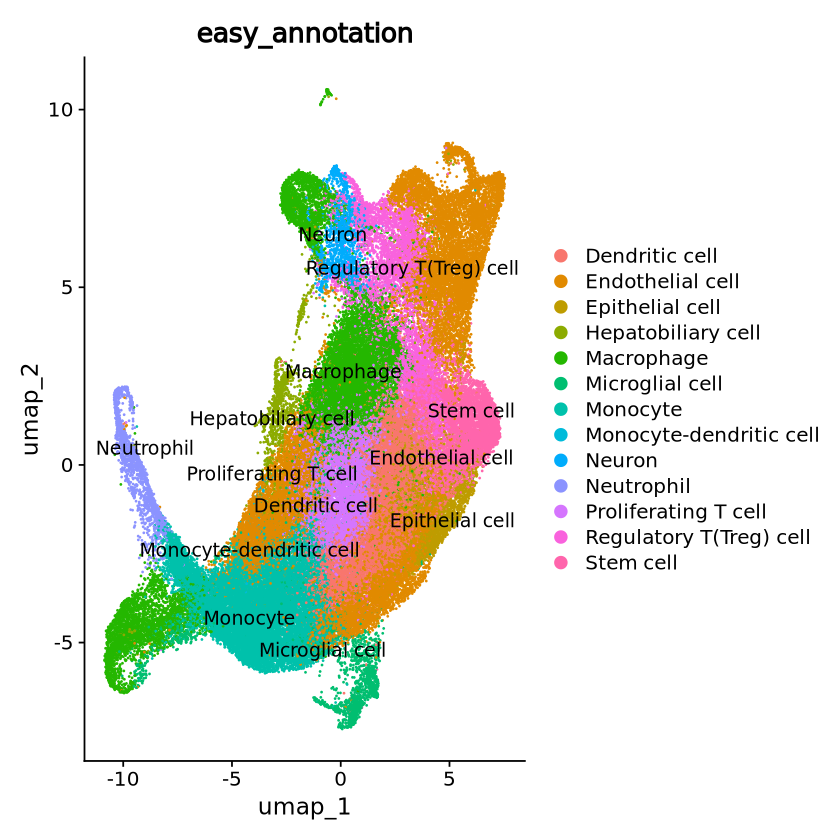

In [23]:
#plot UMAP with cell type labels
cl2cell <-markerTop50Matched[,head(.SD,1),by = .(cluster)]
cl2cell <-setNames(cl2cell[["cell_name"]], cl2cell[["cluster"]])
cl2cell
seurat_int@meta.data[["easy_annotation"]]<-cl2cell[as.character(Idents(seurat_int))]

pdf(file = paste(outDir,"UMAP_byCellType.pdf",sep="/"), height = 14, width = 18)
DimPlot(seurat_int, label = TRUE, group.by = "easy_annotation", repel = TRUE)
dev.off()
DimPlot(seurat_int, label = TRUE, group.by = "easy_annotation", repel = TRUE)

In [24]:
# Save sessionInfo() to a text file
capture.output(sessionInfo(), file = file.path(outDir, "session_info_post_analysis.txt"))